# Concrete Crack Image Classification

In [1]:
import os
import glob
import torch
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    print('CUDA is available! Training on GPU...')
else:
    print('CUDA is not available. Training on CPU...')

CUDA is available! Training on GPU...


## Exploring data

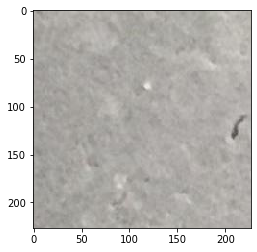

In [3]:
# Quick example
img_path = 'Negative\\00001.jpg' # img_path = 'images/parasite kim.jpeg'
image = Image.open(img_path)
plt.imshow(image)
plt.show()

In [4]:
negative_file_path = 'Negative'

# If there was a directory path
# negative_file_path=os.path.join(directory,negative), string type

os.listdir(negative_file_path)[:5]

['00001.jpg', '00002.jpg', '00003.jpg', '00004.jpg', '00005.jpg']

**Visualize Negative images (with no cracks)**

In [5]:
negative_files=[os.path.join(negative_file_path, file) for file in os.listdir(negative_file_path) if file.endswith(".jpg")]
negative_files.sort()
negative_files[0:5]

['Negative\\00001.jpg',
 'Negative\\00002.jpg',
 'Negative\\00003.jpg',
 'Negative\\00004.jpg',
 'Negative\\00005.jpg']

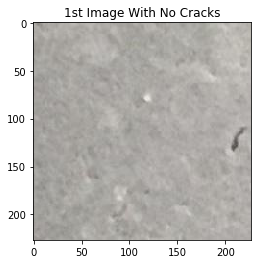

In [6]:
image1 = Image.open(negative_files[0])
plt.imshow(image1)
plt.title("1st Image With No Cracks")
plt.show()

**Visualize Positive images (with cracks)**

In [7]:
positive_file_path = 'Positive'
positive_files = [os.path.join(positive_file_path, file) for file in os.listdir(positive_file_path) if file.endswith('.jpg')]
positive_files.sort()
positive_files[:5]

['Positive\\00001.jpg',
 'Positive\\00002.jpg',
 'Positive\\00003.jpg',
 'Positive\\00004.jpg',
 'Positive\\00005.jpg']

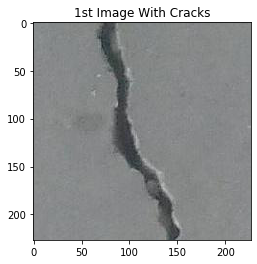

In [8]:
image1 = Image.open(positive_files[0])

plt.imshow(image1)
plt.title("1st Image With Cracks")
plt.show()

## Data preparation

In [9]:
number_of_samples = len(positive_files) + len(negative_files)
number_of_samples

40000

In [10]:
Y = torch.zeros(number_of_samples, dtype=torch.long)
print(Y.shape)

torch.Size([40000])


In [11]:
Y[::2] = 1
Y[1::2] = 0
Y

# a = torch.arange(0, 17)
# print(a)
# print(a[::2])
# print(a[1::2])
# print(a[1::4])

tensor([1, 0, 1,  ..., 0, 1, 0])

In [12]:
all_files=  [None] * number_of_samples
all_files[::2] = positive_files
all_files[1::2] = negative_files
all_files[:5]

# all_files = []
# for x, y in zip(positive_files, negative_files):
#     all_files.append(x)
#     all_files.append(y)

# print(all_files[:5])
# print(len(all_files))

['Positive\\00001.jpg',
 'Negative\\00001.jpg',
 'Positive\\00002.jpg',
 'Negative\\00002.jpg',
 'Positive\\00003.jpg']

**Visualize 4 first imagen in all_files**

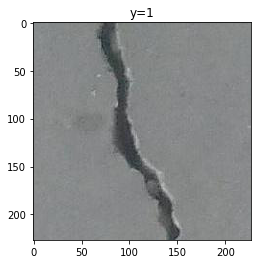

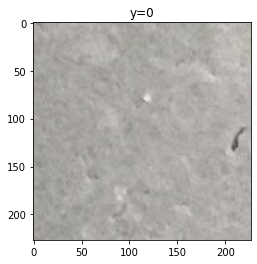

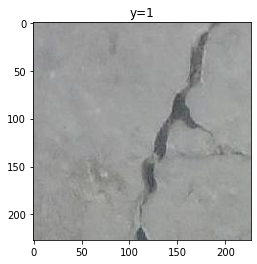

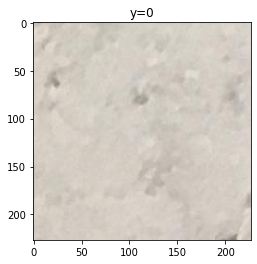

In [13]:
for y, file in zip(Y, all_files[:4]):
    image = Image.open(file)
    plt.title('y='+ str(y.item()))
    plt.imshow(image)
    plt.show()

## Class Dataset

In [14]:
from torch.utils.data import Dataset

class Dataset(Dataset):
    def __init__(self, transform = None, train = True):
        
        # Images
        negative_file_path = 'Negative'
        positive_file_path = 'Positive'
        
        negative_files=[os.path.join(negative_file_path, file) for file in os.listdir(negative_file_path) if file.endswith(".jpg")]
        negative_files.sort()
        positive_files = [os.path.join(positive_file_path, file) for file in os.listdir(positive_file_path) if file.endswith('.jpg')]
        positive_files.sort()
        number_of_samples = len(positive_files) + len(negative_files)
        
        self.all_files = [None] * number_of_samples
        self.all_files[::2] = positive_files
        self.all_files[1::2] = negative_files
            
        self.transform = transform
        
        # Labels
        self.Y = torch.zeros(number_of_samples, dtype = torch.long)
        self.Y[::2] = 1
        self.Y[1::2] = 0
        
        if train:
            self.all_files = self.all_files[:30000]
            self.Y = self.Y[:30000]
            self.len = len(self.all_files)           
        else:
            self.all_files = self.all_files[30000:]
            self.Y = self.Y[30000:]
            self.len = len(self.all_files)
            
    # Get the length
    def __len__(self):
        return self.len
    
    def __getitem__(self, idx):
        
        image = Image.open(self.all_files[idx])
        y = self.Y[idx]
        
        # If there is any transform method, apply it onto the image
        if self.transform:
            image = self.transform(image)

        return image, y

**Answers for test**

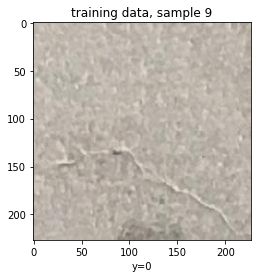

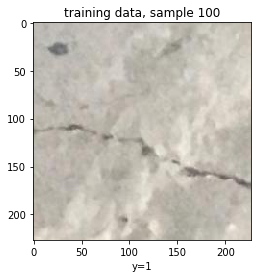

In [15]:
dataset = Dataset()
# dataset[0][0] first image path
# dataset[0][1] first image labels

samples = [9, 100]

for sample in samples:
    plt.imshow(dataset[sample][0])
    plt.xlabel("y="+str(dataset[sample][1].item()))
    plt.title("training data, sample {}".format(int(sample)))
    plt.show()

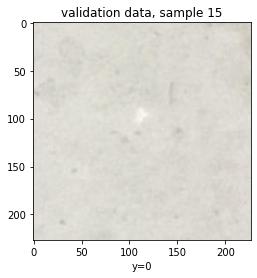

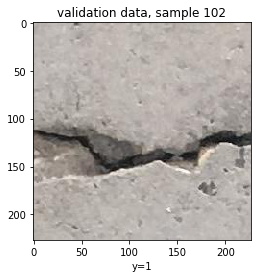

In [16]:
dataset = Dataset(train=False)

samples = [15, 102]

for sample in samples:
    plt.imshow(dataset[sample][0])
    plt.xlabel("y="+str(dataset[sample][1].item()))
    plt.title("validation data, sample {}".format(int(sample)))
    plt.show()

## Datasets and dataloaders

In [17]:
from torchvision import transforms 

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])

# Datasets
trainset = Dataset(transform = transform, train = True)
testset = Dataset(transform = transform, train = False)


# Dataloaders
batch_size = 1000

trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle = True)
testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size, shuffle = True)

## Simple model

In [18]:
import torch.nn as nn

class Classifier(nn.Module):
    def __init__(self, input_size):
        super(Classifier, self).__init__()
        
        self.fc = nn.Linear(input_size, 2)
        
    def forward(self, x):
        
        # flatten images
        x = x.view(x.shape[0], -1) 
        x = self.fc(x)
        
        return x

In [19]:
model = Classifier(input_size = 227*227*3)
model

Classifier(
  (fc): Linear(in_features=154587, out_features=2, bias=True)
)

In [20]:
images, labels = next(iter(trainloader))
images.shape

torch.Size([1000, 3, 227, 227])

In [21]:
if train_on_gpu:
    model.cuda()

### Train and Validation

In [22]:
from torch import optim

learning_rate = 0.1
momentum_term = 0.1

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = momentum_term)

In [23]:
torch.manual_seed(0)

epochs = 5
train_loss_list = []

for epoch in range(epochs):
    train_loss = 0
    
    for images, labels in trainloader:
        if train_on_gpu:
                images, labels = images.cuda(), labels.cuda()

        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss_list.append(train_loss/len(trainloader))    
    
    # prints
    print('Epoch: {} Train loss: {}' .format(epoch + 1, train_loss/len(trainloader)))


Epoch: 1 Train loss: 2464.3870267709094
Epoch: 2 Train loss: 1960.5165557861328
Epoch: 3 Train loss: 1612.5458546956381
Epoch: 4 Train loss: 1054.4976145426433
Epoch: 5 Train loss: 876.3651077270508


In [29]:
correct_total = 0
test_loss = 0

model.eval()
for images, labels in testloader:
    if train_on_gpu:
                images, labels = images.cuda(), labels.cuda()

    output = model(images)
    loss = criterion(output, labels)
    test_loss += loss.item()

    _, pred = torch.max(output, 1)
    correct_total += (pred == labels).sum().item() 

accuracy = correct_total / len(testset)

# Prints
print('\nTest loss: {:.3} \tGlobal accuracy: {:.1%}'.format(test_loss/len(testloader), accuracy))   


Test loss: 4.49e+02 	Global accuracy: 75.7%


## Resnet 18

In [64]:
from torchvision import models

resnet18 = models.resnet18(pretrained = True)
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Dataset and dataloader: resize 224

In [65]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = transforms.Compose([transforms.Resize(224), transforms.ToTensor(), transforms.Normalize(mean, std)])

# Datasets
trainset = Dataset(transform = transform, train = True)
testset = Dataset(transform = transform, train = False)

# Dataloaders
batch_size = 100

trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle = True)
testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size, shuffle = True)

In [66]:
print(resnet18.fc)

Linear(in_features=512, out_features=1000, bias=True)


### Redefine model

In [73]:
# freeze all parameters
for param in resnet18.parameters():
    param.requires_grad = False
    
# new layer automatically have requires_grad = True
last_layer = nn.Linear(512, 2)

# replace last layer
resnet18.fc = last_layer

print(resnet18.fc)

Linear(in_features=512, out_features=2, bias=True)


In [69]:
if train_on_gpu:
    resnet18.cuda()

### Training

In [70]:
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD([parameters for parameters in resnet18.parameters() if parameters.requires_grad == True],
                      lr = learning_rate)

In [71]:
torch.manual_seed(0)

epochs = 5
train_loss_list = []

for epoch in range(epochs):
    train_loss = 0
    
    for images, labels in trainloader:
        if train_on_gpu:
                images, labels = images.cuda(), labels.cuda()

        optimizer.zero_grad()
        output = resnet18(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss_list.append(train_loss/len(trainloader))    
    
    # prints
    print('Epoch: {} Train loss: {}' .format(epoch + 1, train_loss/len(trainloader)))


Epoch: 1 Train loss: 0.3599046877523263
Epoch: 2 Train loss: 0.1688742981851101
Epoch: 3 Train loss: 0.12192335451642672
Epoch: 4 Train loss: 0.09933057131866614
Epoch: 5 Train loss: 0.08667684501657884


### Testing

In [72]:
correct_total = 0
test_loss = 0

model.eval()
for images, labels in testloader:
    if train_on_gpu:
                images, labels = images.cuda(), labels.cuda()

    output = resnet18(images)
    loss = criterion(output, labels)
    test_loss += loss.item()

    _, pred = torch.max(output, 1)
    correct_total += (pred == labels).sum().item() 

accuracy = correct_total / len(testset)

# Prints
print('\nTest loss: {:.3} \tGlobal accuracy: {:.1%}'.format(test_loss/len(testloader), accuracy))   


Test loss: 0.0812 	Global accuracy: 98.7%


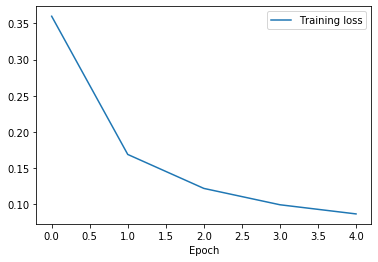

In [96]:
plt.plot(train_loss_list, label = 'Training loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()